# CS 109A/STAT 121A/AC 209A/CSCI E-109A: Homework 4 
# Advanced Part (209A) Solutions

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine

In [1]:
from io import BytesIO
from zipfile import ZipFile
import urllib
import os

# Note that you may need to run the following command to install Python Image Library (PIL)
#pip install Pillow
from PIL import Image
import numpy as np
from sklearn.cross_validation import train_test_split

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

/Users/eleni/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# starter functions provided to students
def rgb2gray(rgb):
    '''
    function to convert RGB image to gray scale
    accepts 3D numpy array and returns 2D array with same dimensions
    as the first two dimensions of input
    '''
    
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def fetch_and_read_data(shape=(50,30)):
    
    '''
    Function to download image data, store in a local folder (note this is 18.4mb), only download the data when
    the local folder is not present, read in the images, downsample them to the specified shape (default = (50x30) (rows x cols))
    and finally split them into a four tuple return object.
    
    Returns:
        - 1) training image data (i.e. images that should form the predictor matrix in your solution)
        - 2) training image data labels (i.e. labels from 1 to 50 that identify which face (1) belongs to)
        - 3) testing image data (i.e. data that you should use to try and classify - note this forms the predictor variable in your regression)
        - 4) testing image data labels (i.e. the labels for (3) - this is to allow you to evaluate your model)
    
    ___________________
    Aside:
    If you want to change the sampling dimensions of your data, pass the shape = (x,y) argument to the method where
    y is the number of columns and x is the number of rows in the image.
    '''
    
    if not os.path.exists('./cropped_faces'):
        url = urllib.request.urlopen("http://www.anefian.com/research/GTdb_crop.zip")
        
        zipfile = ZipFile(BytesIO(url.read()))
        zipfile.extractall()
     
    data = []
    labels = []
    
    files = os.listdir('cropped_faces')
    for f in files:
        if '.jpg' in f:
            image = Image.open('cropped_faces/' + f)
            image = image.resize((shape[1], shape[0]))
            data.append(rgb2gray(np.asarray(image)))
            labels.append(int(f.split('_')[0][1:]) - 1)
            
    data = np.array(data)
    
    trainX, testX, trainY, testY = train_test_split(data, labels, test_size=0.2, stratify=labels)
    return np.array(trainX), np.array(testX), np.array(trainY), np.array(testY)

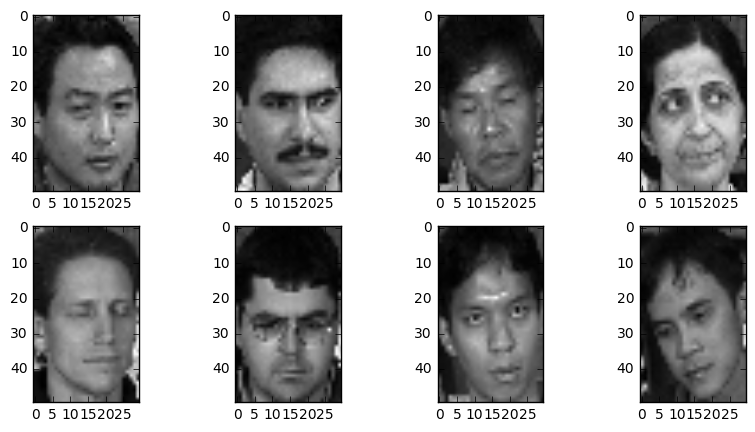

In [3]:
# starter code for the students
train_dataset, test_dataset, train_labels, test_labels = fetch_and_read_data()

# code to plot some of the images
fig, axes = plt.subplots(2,4,figsize=(10,5))
axes = axes.flatten()
[axes[i].imshow(train_dataset[i], cmap='gray') for i in range(len(axes))]
plt.show()

# APCOMP209a - Homework Question

Read Sections 1 and 2 of this [paper](https://www.researchgate.net/profile/Roberto_Togneri/publication/45094554_Linear_Regression_for_Face_Recognition/links/09e4150d243bd8b987000000/Linear-Regression-for-Face-Recognition.pdf). 

Briefly, we have a number of cleaned images of people's faces. The model leverages the concept that "patterns from a single-object class lie on a linear subspace" and the fact that linear regression can be thought of as an orthogonal projection of the response vector (Y) onto the subspace spanned by the columns of the predictor matrix (X).

## Question 1

### Question 1a

As discussed in the linked paper, we have face data that has images of faces belonging to different people. Going with the assumption that patterns (faces) of one type (from one person) form part of the same linear subspace, let's try to classify some unknown faces by the same method presented in the paper. In other words, construct hat (H) matrices from known faces (make sure you follow the column concatenation step described in the paper to convert an image into a vector representation), and project the unknown face vectors onto the subspaces spanned by the various H matrices. Calculating the minimum distance between the original vector and the projection should allow you to make a classification of the face.

**Notes:**
    - Use the provided code to download and re-sample the dataset.
    - Follow the normalisation step in the paper to ensure the "maximum pixel value is 1".
    - Your classifier should have approximately an 80% accuracy
    - Use the image plotting library of matplotlib to display one (or two) correctly classified faces and the known faces.
    - Use the image plotting library of matplotlib to display one (or two) incorrectly classified faces and the known faces.

**Text ansewer required:**
    - provide a reasonable explination for the mis-classified faces.
    
### Question 1b - Significant Faces
Select an example of a correctly classified face. Use statsmodels to investigate the most predictive columns (faces) that the model used in this regression:

(i) Which columns (i.e. faces) make the highest contribution to the projection?

(ii) Which columns (i.e. faces) are the least useful in making this projection?

Plot the correctly assigned face, and the two faces from the questions (i) and (ii). What do you notice about these faces?

<hr/ >
<hr/ >

### Question 1 Solution

In [4]:
number_of_faces = len(set(train_labels))

In [5]:
H_matrices = []
face_dataset = []

# build the 'X' matrix for each face
for i in range(0, number_of_faces):
    
    xs = train_dataset[train_labels == i]
    
    # follow the column concat method presented in the paper
    X = np.concatenate([np.concatenate(xi, axis=0).reshape(-1,1) for xi in xs], axis=1)
    
    face_dataset.append(X)
    
    # follow the normalisation step outlined in the paper
    X = X/np.max(X, axis=0)
    
    # build the hat matrices for each face and store for use later on
    H_matrices.append(X.dot(np.linalg.pinv(X.T.dot(X))).dot(X.T))

In [6]:
ys = test_dataset
Y = np.array([np.concatenate(yi, axis=0) for yi in ys])

# note that the Y vectors here represent the unclassified vector that we will project onto the 
# the relevant subspaces
Y = Y/np.max(Y, axis=1).reshape(-1,1)

In [7]:
assignments = []

for k, y_unknown in enumerate(Y):
    
    # here we project the y_unknown onto all of the known subspaces
    proj = np.array([H.dot(y_unknown) for H in H_matrices])

    # calculate the distance parameters between the projections and the real vector Y
    distance = np.linalg.norm(y_unknown - proj, axis=1)
    
    # make a classification decision
    assignment = np.argmin(distance)
    assignments.append(assignment)

assignments = np.array(assignments)

In [8]:
print('Percent accuracy: {}%'.format(np.mean(assignments == test_labels)*100))

Percent accuracy: 82.66666666666667%


# See some of the faces that it got correct:

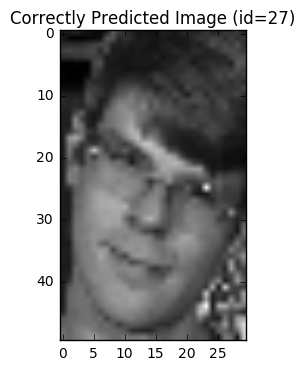

In [9]:
correct = test_labels[assignments == test_labels][:2] # i.e. choose two correct labels

plt.imshow(test_dataset[test_labels == correct[0]][0], cmap='gray')
plt.title("Correctly Predicted Image (id={})".format(correct[0]))
plt.show()

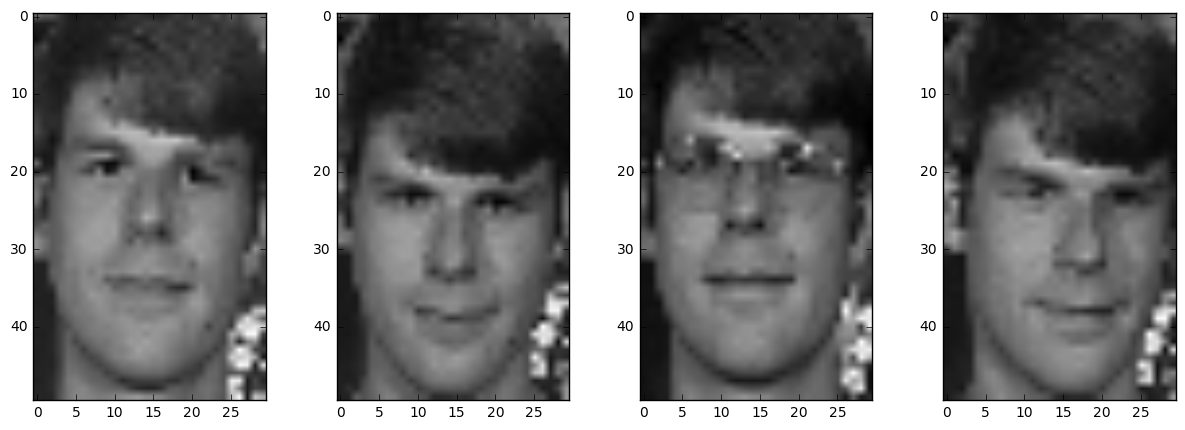

In [10]:
fig, axes = plt.subplots(1,4,figsize=(15,5))
axes = axes.flatten()
[axes[i].imshow(img, cmap='gray') for i, img in enumerate(train_dataset[train_labels == correct[0]][:4])]
plt.show()

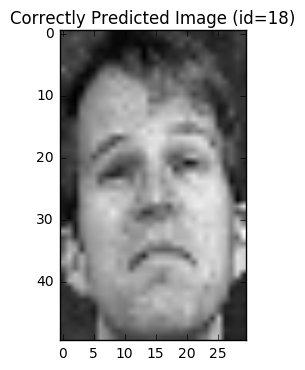

In [11]:
plt.imshow(test_dataset[test_labels == correct[1]][0], cmap='gray')
plt.title("Correctly Predicted Image (id={})".format(correct[1]))
plt.show()

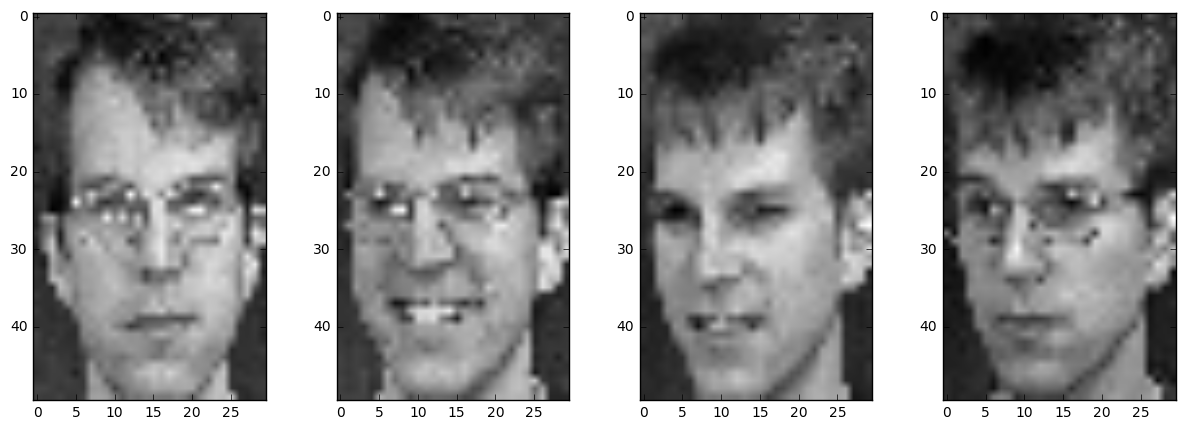

In [12]:
fig, axes = plt.subplots(1,4,figsize=(15,5))
axes = axes.flatten()
[axes[i].imshow(img, cmap='gray') for i, img in enumerate(train_dataset[train_labels == correct[1]][:4])]
plt.show()

# See some of the faces that it got incorrect:

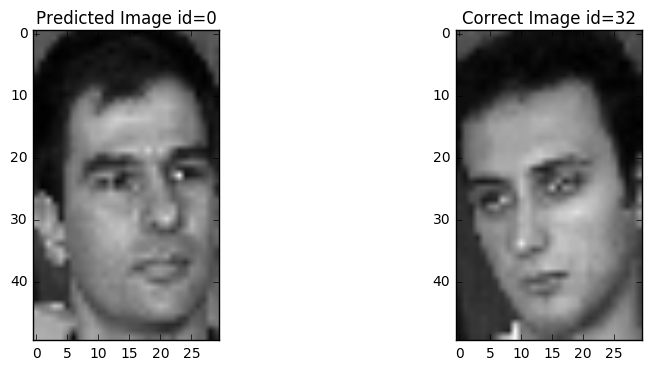

In [13]:
incorrect = assignments[assignments != test_labels][:2]
incorrect_corrected = test_labels[assignments != test_labels][:2]

fig, axes = plt.subplots(1,2,figsize=(10,4))

axes[0].imshow(test_dataset[test_labels == incorrect[0]][0], cmap='gray')
axes[0].set_title("Predicted Image id={}".format(incorrect[0]))

axes[1].imshow(test_dataset[test_labels == incorrect_corrected[0]][0], cmap='gray')
axes[1].set_title("Correct Image id={}".format(incorrect_corrected[0]))

plt.show()

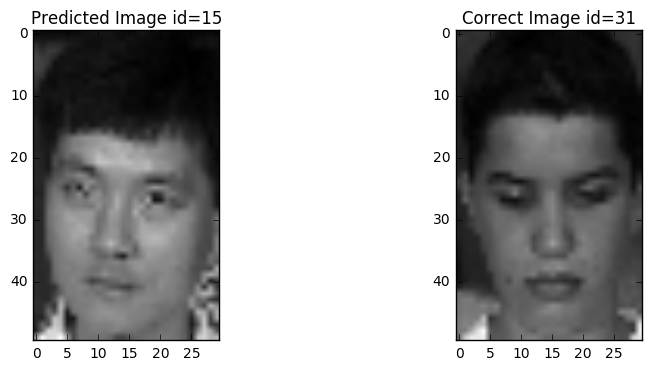

In [14]:
fig, axes = plt.subplots(1,2,figsize=(10,4))

axes[0].imshow(test_dataset[test_labels == incorrect[1]][0], cmap='gray')
axes[0].set_title("Predicted Image id={}".format(incorrect[1]))

axes[1].imshow(test_dataset[test_labels == incorrect_corrected[1]][0], cmap='gray')
axes[1].set_title("Correct Image id={}".format(incorrect_corrected[1]))

plt.show()

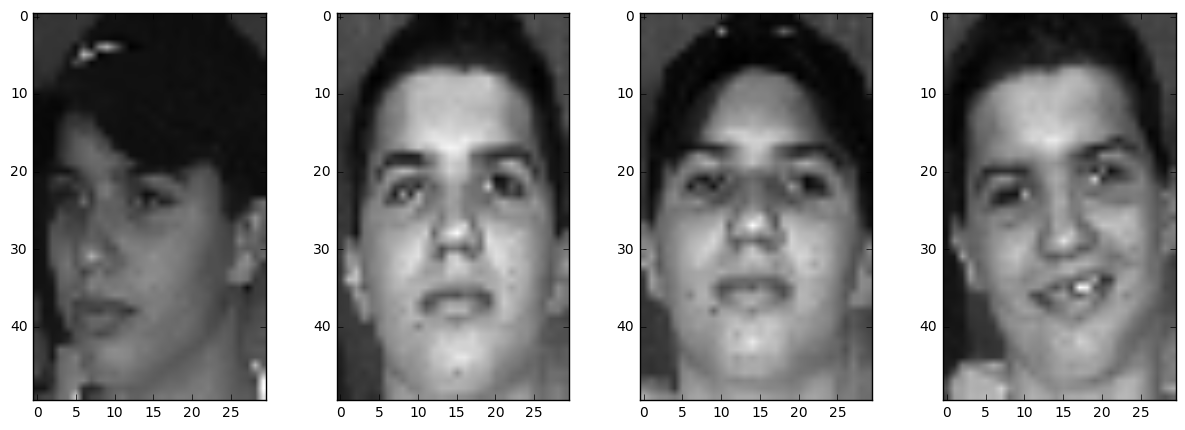

In [15]:
fig, axes = plt.subplots(1,4,figsize=(15,5))
axes = axes.flatten()
[axes[i].imshow(img, cmap='gray') for i, img in enumerate(train_dataset[train_labels == incorrect_corrected[1]][:4])]
plt.show()

# Significant Faces (Question 2b - solution)

In [19]:
import statsmodels.api as sm
from scipy import stats

example_of_correct_assignment = test_labels[(assignments==test_labels)][1]

# take the first face as an example
y = Y[(assignments==test_labels)][1]
X = face_dataset[example_of_correct_assignment]

est = sm.OLS(y, X)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     2419.
Date:                Tue, 26 Sep 2017   Prob (F-statistic):               0.00
Time:                        20:33:08   Log-Likelihood:                 946.28
No. Observations:                1500   AIC:                            -1869.
Df Residuals:                    1488   BIC:                            -1805.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0002      0.000      1.476      0.1

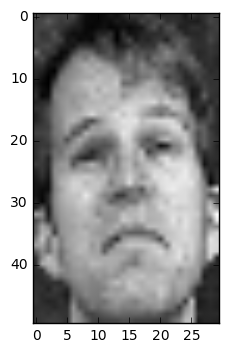

In [20]:
fig, ax = plt.subplots(1,1)
ax.imshow(y.reshape(50,30), cmap='gray')
plt.show()

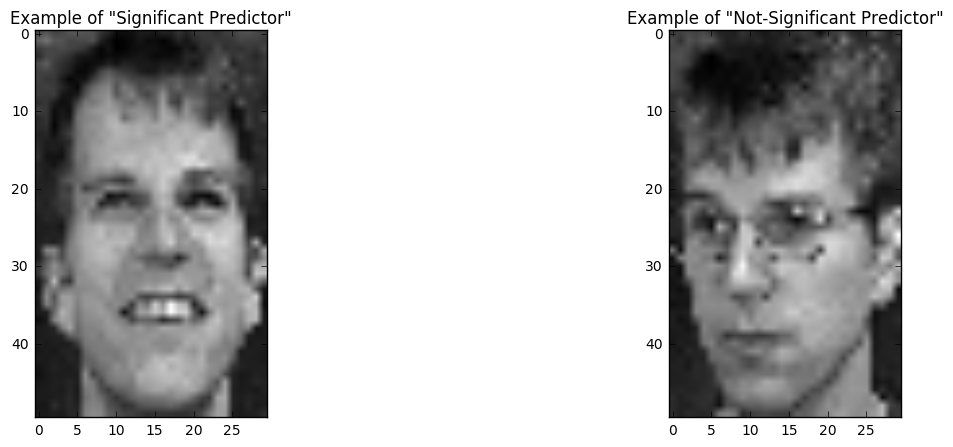

In [21]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].imshow(X[:,6-1].reshape(50,30), cmap='gray')
ax[0].set_title('Example of "Significant Predictor"')

ax[1].imshow(X[:,4-1].reshape(50,30), cmap='gray')
ax[1].set_title('Example of "Not-Significant Predictor"')

plt.show()

The vector that is significant in the projection also 'heuristically' looks like the face that we are trying to predict. The face that was not significant looks almost entirely different.